In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time
from ipywidgets import interact
from numba import jit

In [2]:
plt.rcParams['figure.figsize'] = [5, 5]

# Check if polygon is valid

In [3]:
@jit 
def ccw(p1,p2,p3):
    (x1,y1) = p1
    (x2,y2) = p2
    (x3,y3) = p3
    return (y3-y1) * (x2-x1) > (y2-y1) * (x3-x1)
@jit
def intersect(p1,p2,p3,p4):
    (x1,y1) = p1
    (x2,y2) = p2
    (x3,y3) = p3
    (x4,y4) = p4
    test1 = ccw((x1,y1),(x3,y3),(x4,y4)) != ccw((x2,y2),(x3,y3),(x4,y4))
    test2 = ccw((x1,y1),(x2,y2),(x3,y3)) != ccw((x1,y1),(x2,y2),(x4,y4))
    return test1 and test2

@jit
def valid_polygon(point_array):
    l = point_array.shape[0]
    for i in range(-1, l - 1):
        p1, p2 = point_array[i],point_array[i+1]
        for j in range(-1,l - 1):
            if j%l == i%l or j%l == (i+1)%l or j%l == (i-1)%l:
                continue
            p3, p4 = point_array[j],point_array[j+1]
            if intersect(p1,p2,p3,p4):
                return False
    return True

In [4]:
def plot_polygon_valid(x, y):
    x_arr, y_arr = [0, 1, x, 0, 0], [0, 0, y, 1, 0]
    plt.plot(x_arr, y_arr)
    plt.title(f'Valid Polygon {valid_polygon(np.array(list(zip(x_arr, y_arr)))[:-1])}')
    plt.ylim([-3, 3])
    plt.xlim([-3, 3])
    plt.show()

# Use interact to create an interactive plot
interact(plot_polygon_valid, x=(-3, 2, 0.1), y=(-3, 2, 0.1)) 

interactive(children=(FloatSlider(value=-1.0, description='x', max=2.0, min=-3.0), FloatSlider(value=-1.0, des…

<function __main__.plot_polygon_valid(x, y)>

# Check if polygon is in bounds

In [5]:

@jit
def line_segment_in_bounds(p1, p2):
    x1, y1  = p1
    x2, y2  = p2
    # if points in opposing quadrants and intercept wwith y = x is negative
    if max(x1, x2) > 0 and min(x1, x2) < 0 and max(y1, y2) > 0 and min(y1, y2) < 0:
        if ((y1 * (x2 - x1) - x1 * (y2 - y1)) < 0) ^ ((x2 - x1 - y2 + y1) < 0):
            return False
    return True

@jit
def in_bounds(point_array):
    if np.any(point_array>1):
        return False
    if np.any(np.bitwise_and(point_array[:,0]<0,point_array[:,1]<0)):
        return False
    for i in range(-1,point_array.shape[0] - 1):
        if not line_segment_in_bounds(point_array[i],point_array[i+1]):
            return False
    return True

@jit
def finished(point_array):
    if np.all(point_array[:,0]>=0):
        return True
    else:
        return False

In [6]:
def plot_polygon_inbounds(x, y):
    point_arr = np.array([[1, 1], [1, 0], [0, 1], [1, 1]]) * 0.8
    point_arr[:, 0] += x
    point_arr[:, 1] += y
    plt.plot(point_arr[:,0], point_arr[:,1])
    plt.plot((-3,0,0),(0,0,-3))
    plt.plot((-3,1,1),(1,1,-3))
    plt.title(f'In bounds Polygon {in_bounds(point_arr[:-1])}, Finished {finished(point_arr[:-1])}')
    plt.ylim([-3, 3])
    plt.xlim([-3, 3])
    plt.show()

# Use interact to create an interactive plot
interact(plot_polygon_valid, x=(-3, 2, 0.1), y=(-3, 2, 0.1)) 

interactive(children=(FloatSlider(value=-1.0, description='x', max=2.0, min=-3.0), FloatSlider(value=-1.0, des…

<function __main__.plot_polygon_valid(x, y)>

# Define movement function

## Rotation

In [7]:
@jit
def get_max_angle(point_array):
    """check maximum rotation about (0,0)"""
    max_angle = 2*math.pi
    for point in point_array:
        radius = np.sum(np.square(point))**0.5
        current_angle = math.atan2(point[1],point[0])
        if current_angle < -2:
            current_angle += 2 * math.pi
        if radius>1:
            circle_angle = math.acos(1/radius)
            if current_angle >= math.pi/2: 
                min_angle = current_angle - math.pi/2 - circle_angle
            elif current_angle >= 0:
                min_angle = current_angle - circle_angle
            else:
                min_angle = current_angle + math.pi / 2
        else:
            min_angle = current_angle + math.pi / 2
        max_angle = min(min_angle,max_angle)
    return -max_angle

@jit
def rotate_points(point_array, angle):
    rot = np.array([[math.cos(angle), -math.sin(angle)], [math.sin(angle), math.cos(angle)]])
    return np.dot(point_array,rot.T)

In [8]:
def plot_polygon_rotation(fraction):
    point_arr = np.array([[1, 1], [1, 0], [0, 1], [1, 1]]) * 0.8
    point_arr -= np.array((1, 0))
    plt.plot(point_arr[:,0], point_arr[:,1])
    plt.plot(*zip(*rotate_points(point_arr, fraction * get_max_angle(point_arr))))
    plt.plot((-3,0,0),(0,0,-3))
    plt.plot((-3,1,1),(1,1,-3))
    plt.title(f'Polygon Angle {get_max_angle(point_arr)}')
    plt.ylim([-3, 3])
    plt.xlim([-3, 3])
    plt.show()

# Use interact to create an interactive plot
interact(plot_polygon_rotation, fraction=(0, 1, 0.1)) 

interactive(children=(FloatSlider(value=0.0, description='fraction', max=1.0), Output()), _dom_classes=('widge…

<function __main__.plot_polygon_rotation(fraction)>

In [9]:
@jit
def get_max_height_drop(point_array):
     # points under x < 0 cannot go below y = 0
    drop_y = np.min(point_array[:,1][point_array[:,0]<0])
    # points above x > 0 can go as low as needed but their edges cannot go below (0, 0)
    for i in range(-1,point_array.shape[0]-1):
        p1, p2 = point_array[i],point_array[i+1]
        x1, y1  = p1
        x2, y2  = p2
        if max(x1, x2) > 0 and min(x1, x2) < 0:
            this_drop_limit = (x2 * y1 - x1 * y2) / (x2 - x1)
            drop_y = min(drop_y, this_drop_limit)
    return drop_y

        
def pass_through(point_array, max_steps, angle_multiplier = 0.9, translation_multiplier = 0.9, plot_graph_delay = 0):
    for steps in range(max_steps):
        stuck = True

        #Move down as much as possible
        disty = get_max_height_drop(point_array)
        if disty != 0:
            stuck = False
        point_array -= np.array((0, disty * 0.99))

        #Rotate about 0,0 mostly
        angle = get_max_angle(point_array)
        if angle != 0:
            stuck = False
        point_array = rotate_points(point_array, angle*angle_multiplier)

        #Move ahead mostly
        distx = np.min(1 - point_array[:,0])
        if distx > 0:
            stuck = False
        point_array += np.array((distx*translation_multiplier, 0))
            
        #End condition
        if finished(point_array):
            stuck = False
            break
        
        if stuck:
            break
        
        #Plot
        if plot_graph_delay > 0:
            time.sleep(plot_graph_delay)
            plt.title(f"Iteration {steps}, {in_bounds(point_array)}")
            plt.plot(np.append(point_array[:,0], point_array[0,0]), 
                     np.append(point_array[:,1], point_array[0,1]))
            plt.plot((-3,1,1),(1,1,-3))
            plt.plot((-3,0,0),(0,0,-3))
            plt.show()
            clear_output(wait=True)
            
        #End condition
        if finished(point_array):
            stuck = False
            break
        if stuck:
            break

    if not stuck and steps < max_steps-1:
        return True
    else:
        return False

# New scipy optimization

In [10]:
from threading import Lock

ITERATIONS = 100

@jit
def area(point_array):
    x, y = point_array[:,0], point_array[:,1]
    return np.abs(1/2 * np.sum(x*np.roll(y, 1) - y*np.roll(x, 1)))

def valid(point_array):
    point_array = np.array(point_array)
    return (not finished(point_array)) and valid_polygon(point_array) and in_bounds(point_array) and pass_through(point_array, ITERATIONS)

def get_bounds(points):
    return sum(map(list, zip([(-3, 1)] * len(points), [(0,1)] * len(points))), start=[])

def get_average_sidelength(points):
    distances = np.sqrt(np.sum(np.square(points - np.roll(points, -1, axis=0)), axis=1))
    return np.mean(distances)

display_time = time.time()
display_lock = Lock()

def metric(flattened):
    global display_time
    point_array = np.array(flattened).reshape((-1, 2))
    if valid(point_array):
        with display_lock:
            if (time.time() - display_time) > 30:
                pass_through(point_array, ITERATIONS, plot_graph_delay=0.05)
                display_time = time.time()
        return -area(point_array)
    else:
        return 0

# Polygon manipulation

In [11]:
def reduce_useless_points(og_point_array):
    while True:
        initial_shape = og_point_array.shape
        for i in reversed(range(og_point_array.shape[0])):
            og_point_array2 = np.vstack([og_point_array[:i], og_point_array[i+1:]])
            if area(og_point_array2) >= area(og_point_array):
                if metric(og_point_array2) <= metric(og_point_array):
                    og_point_array = og_point_array2
        if og_point_array.shape == initial_shape:
            break
    return og_point_array

def add_more_points_to_optimize(og_point_array, target_n):
    distances = np.sqrt(np.sum(np.square(og_point_array - np.roll(og_point_array, -1, axis=0)), axis=1))
    perimiter = np.sum(distances, axis=0)
    target_dist = perimiter / target_n
    add_points = (distances // target_dist).astype(np.int32)
    point_list = list(og_point_array)
    point_list.append(point_list[0])
    final_points = []
    for points_to_add in add_points:
        final_points.append(point_list.pop(0))
        if points_to_add > 0:
            x1, y1 = final_points[-1]
            x2, y2 = point_list[0]
            interpolated = np.dstack([np.linspace(x1, x2, 2+points_to_add), np.linspace(y1, y2, 2+points_to_add)])[0][1:-1]
            final_points.append(interpolated)
    return np.vstack(final_points)

# Starting point

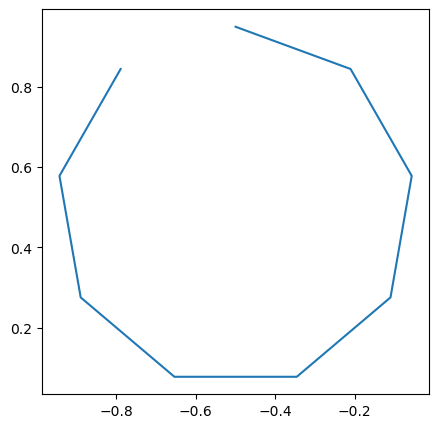

In [12]:
# starting points will be a regular n-gon
n = 10

angles = np.linspace(0, 3.1416*2, n)[:-1]
points = np.vstack([np.sin(angles), np.cos(angles)]).T
points *= 0.45
points[:, 0] -= 0.5
points[:, 1] += 0.5
plt.plot(*zip(*points))
plt.show()

In [13]:
metric(points)

-0.5857402093206147

# Scipy optimize

In [14]:
from scipy import optimize

In [15]:
while len(points) < 50:
    x = optimize.differential_evolution(metric, bounds=get_bounds(points), x0 = points.flatten(), 
    mutation = (0, get_average_sidelength(points)/2), seed=1)
    points = np.array(x.x).reshape(-1, 2)
    points = reduce_useless_points(points)
    points = add_more_points_to_optimize(points, len(points)+5)
    print(x, len(points))

 message: Optimization terminated successfully.
 success: True
     fun: -1.7793433373916154
       x: [-6.507e-01  9.958e-01 ... -7.563e-01  9.356e-01]
     nit: 30
    nfev: 44733 64


# The end

In [16]:
points = reduce_useless_points(points)

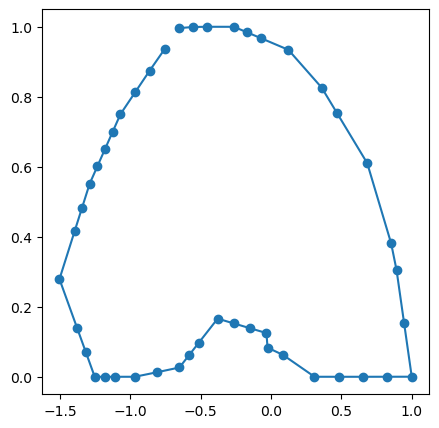

 message: Optimization terminated successfully.
 success: True
     fun: -1.7793433373916154
       x: [-6.507e-01  9.958e-01 ... -7.563e-01  9.356e-01]
     nit: 30
    nfev: 44733
1.7815024965510924


In [17]:
plt.plot(*zip(*np.array(points).reshape(-1, 2)))
plt.scatter(*zip(*np.array(points).reshape(-1, 2)))
plt.show()
print(x)
print(area(points))

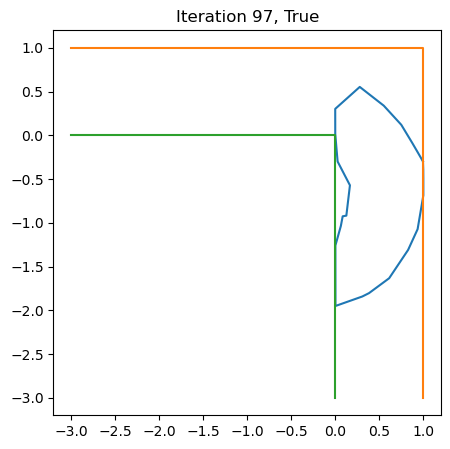

In [18]:
result = pass_through(points, ITERATIONS, plot_graph_delay=0.2)

In [19]:
result

True